In [1]:
import numpy as np
import pandas as pd
import os 
from collections import OrderedDict
import time
import deepdish.io as dd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from utils.inference import SVI
import utils.models as m
from utils.layers import *
from utils.inception import *
import utils.datasets as d

In [2]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [4]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=512, shuffle=True)

# ResNetVAE

In [7]:
mod = m.ResNetVAE(channels=[32, 64, 64, 128], latent_space_dim=30, activation=nn.LeakyReLU())

In [8]:
optimizer = torch.optim.Adam(mod.parameters(), lr=1e-3)

In [9]:
svi = SVI(
        vae_model=mod,
        optimizer=optimizer,
        loss_function="GaussianNLL",
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1),
        tensorboard=True,
        model_name = "ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30",
        verbose=True
        )

cuda:0


In [10]:
lh = svi(epochs=200, train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [1/200], average_loss:180.4899, validation_loss:35.6253
Epoch [2/200], average_loss:0.2714, validation_loss:73.2057
Epoch [3/200], average_loss:-32.9285, validation_loss:-81.8643
Epoch [4/200], average_loss:-54.1532, validation_loss:-93.8968
Epoch [5/200], average_loss:-66.8873, validation_loss:-95.8881
Epoch [6/200], average_loss:-77.1296, validation_loss:-40.6727
Epoch [7/200], average_loss:-68.0864, validation_loss:-94.8488
Epoch [8/200], average_loss:-78.7704, validation_loss:-102.6795
Epoch [9/200], average_loss:-95.3677, validation_loss:-43.3042
Epoch [10/200], average_loss:-98.3605, validation_loss:-131.0638
Epoch [11/200], average_loss:-96.0635, validation_loss:-134.8702
Epoch [12/200], average_loss:-104.0980, validation_loss:-100.3673
Epoch [13/200], average_loss:-102.2186, validation_loss:-128.2491
Epoch [14/200], average_loss:-110.2983, validation_loss:-124.6967
Epoch [15/200], average_loss:-98.1726, validation_loss:-108.7150
Epoch [16/200], average_loss:-94.7336, vali

Epoch [126/200], average_loss:-191.2319, validation_loss:-202.5470
Epoch [127/200], average_loss:-193.2178, validation_loss:-204.4573
Epoch [128/200], average_loss:-192.8540, validation_loss:-188.2341
Epoch [129/200], average_loss:-194.8940, validation_loss:-201.5721
Epoch [130/200], average_loss:-197.0591, validation_loss:-204.7300
Epoch [131/200], average_loss:-193.2908, validation_loss:-206.2810
Epoch [132/200], average_loss:-194.5184, validation_loss:-203.7824
Epoch [133/200], average_loss:-196.1610, validation_loss:-203.4080
Epoch [134/200], average_loss:-198.5423, validation_loss:-201.6563
Epoch [135/200], average_loss:-195.8660, validation_loss:-206.2181
Epoch [136/200], average_loss:-197.9555, validation_loss:-194.9496
Epoch [137/200], average_loss:-196.6900, validation_loss:-209.8992
Epoch [138/200], average_loss:-205.0880, validation_loss:-215.8546
Epoch [139/200], average_loss:-205.2970, validation_loss:-219.5826
Epoch [140/200], average_loss:-206.4976, validation_loss:-205.

In [11]:
lh = svi(epochs=range(200, 300), train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [201/300], average_loss:-228.7901, validation_loss:-238.7012
Epoch [202/300], average_loss:-230.2182, validation_loss:-245.0153
Epoch [203/300], average_loss:-231.1243, validation_loss:-244.3925
Epoch [204/300], average_loss:-229.6185, validation_loss:-235.2863
Epoch [205/300], average_loss:-231.8875, validation_loss:-243.3525
Epoch [206/300], average_loss:-224.7844, validation_loss:-233.9107
Epoch [207/300], average_loss:-227.7220, validation_loss:-226.1364
Epoch [208/300], average_loss:-226.1095, validation_loss:-241.2313
Epoch [209/300], average_loss:-225.5095, validation_loss:-244.4025
Epoch [210/300], average_loss:-230.2747, validation_loss:-235.2476
Epoch [211/300], average_loss:-232.9757, validation_loss:-245.1046
Epoch [212/300], average_loss:-236.0847, validation_loss:-245.2711
Epoch [213/300], average_loss:-226.8423, validation_loss:-242.9925
Epoch [214/300], average_loss:-229.4879, validation_loss:-241.4644
Epoch [215/300], average_loss:-230.3658, validation_loss:-240.

cuda:0


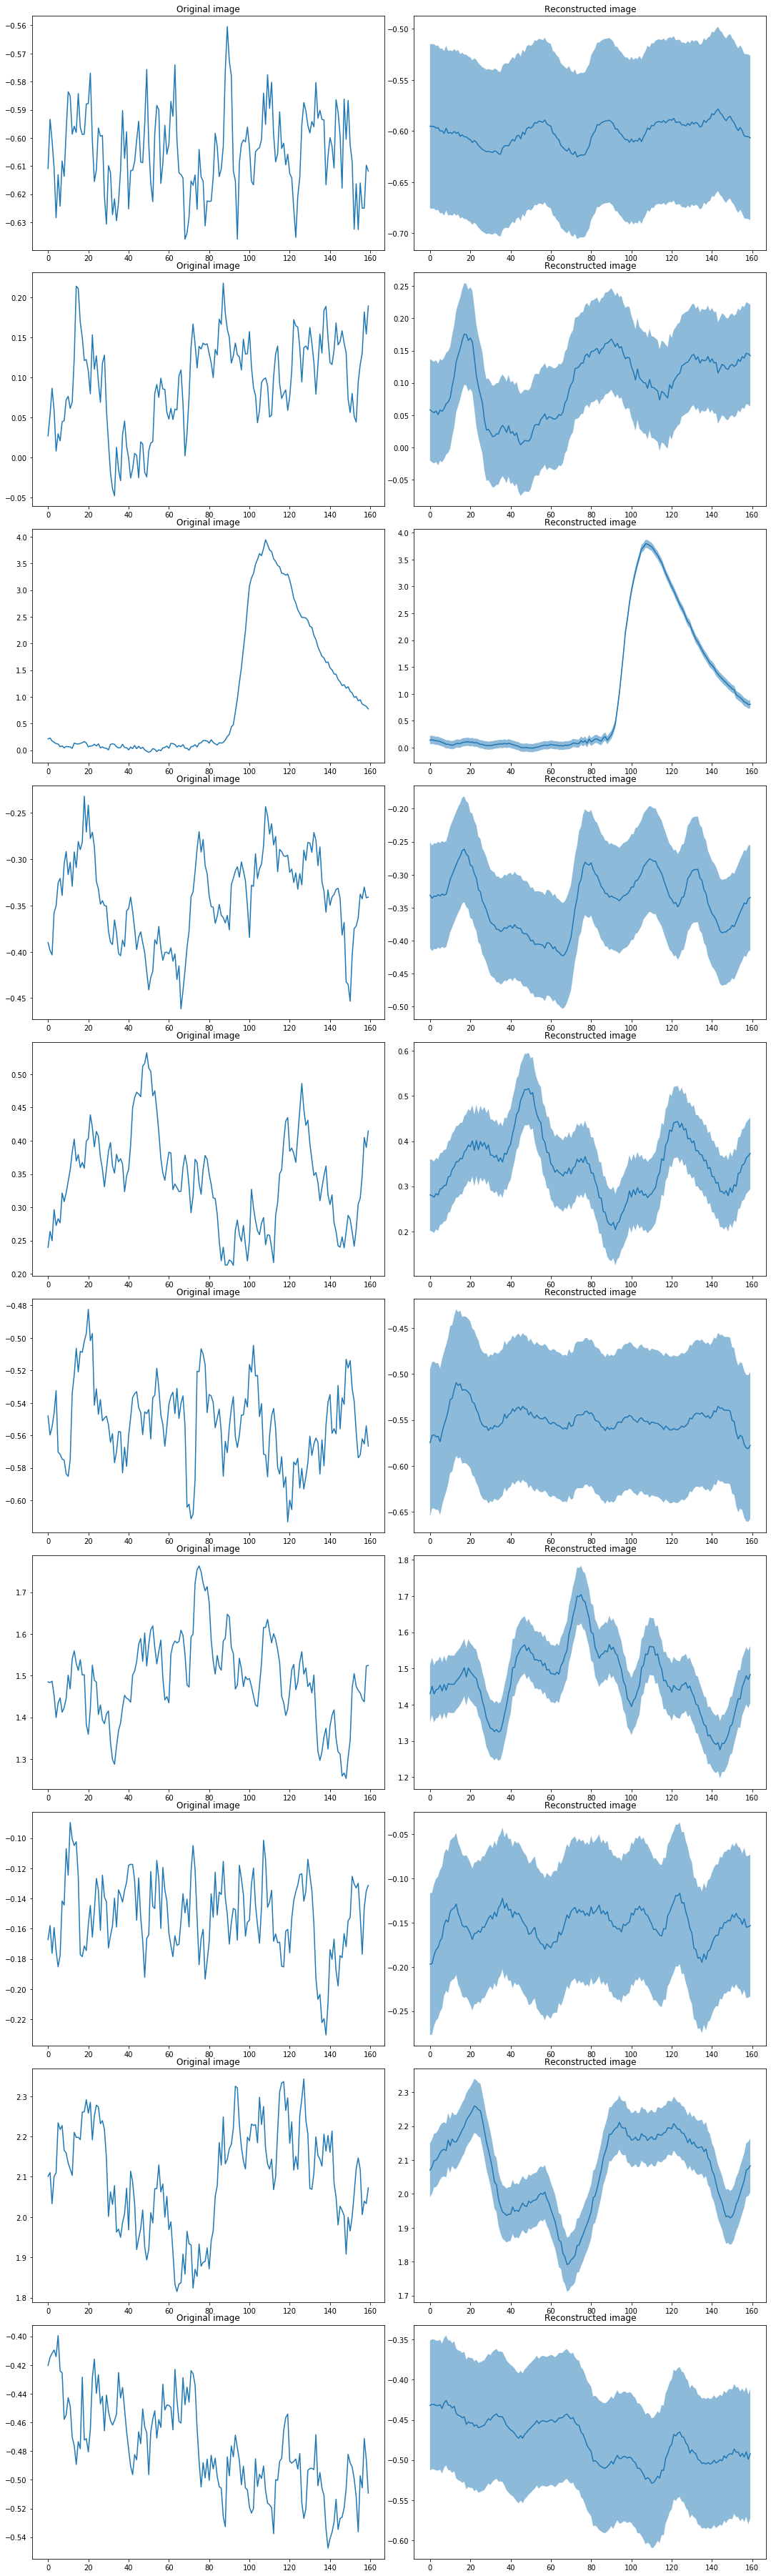

In [12]:
# epoch 300
print(svi.device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(svi.device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

In [ ]:
#torch.save(svi.model, "models_and_losses/ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30_epoch-300.pt")
#torch.save(svi.model.state_dict(), "models_and_losses/ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30_epoch-300_state_dict.pt")
#torch.save(svi.optimizer, "models_and_losses/ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512_ls-30_epoch-300_optimizer.pt")

In [ ]:
# epoch 300
X_1, cl = test.X, test.y
Z_hat, mu, sigma = svi.model.encoder(X_1.to(svi.device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Z_hat[:,0], Z_hat[:,1], Z_hat[:,2], c=cl, lw=3)
sc = ax.scatter(mu[:,0], mu[:,1], mu[:,2], c=cl, lw=3)

# T-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
model = m.ResNetVAE(channels=[32,64,64,128], activation=nn.LeakyReLU())

In [ ]:
model.load_state_dict(torch.load("models_and_losses/ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300_state_dict.pt"))

In [ ]:
X_1, cl = X_test, y_test
model.cuda()
Z_hat, mu, sigma = model.encoder(torch.tensor(X_1).float().to(device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

In [ ]:
X_RN = TSNE(n_components=3, verbose=True).fit_transform(mu)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_RN[:,1], X_RN[:,2], X_RN[:,0], c=cl, lw=3)

In [ ]:
np.save("RES")